Project: Pairs Trading Strategy
By: Rex Manglicmot
Date: 4/6/25

Goal of the project is to build a market-neutral trading strategy using a pair fo stocks that move together over time (cointegrated). When their price relationship diverges, bet on reversion.

In [53]:
# Import the libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

In [54]:
# Download 5 years worth of daily data from Yahoo finance
tickers = ['NVDA', 'AMD']
raw_data = yf.download(tickers, start='2018-01-01', end='2023-12-31')

# Show the columns
print(raw_data.columns)

[*********************100%***********************]  2 of 2 completed

MultiIndex([( 'Close',  'AMD'),
            ( 'Close', 'NVDA'),
            (  'High',  'AMD'),
            (  'High', 'NVDA'),
            (   'Low',  'AMD'),
            (   'Low', 'NVDA'),
            (  'Open',  'AMD'),
            (  'Open', 'NVDA'),
            ('Volume',  'AMD'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])


In [55]:
raw_data.head()

Price       Close             High              Low             Open  \
Ticker        AMD      NVDA    AMD      NVDA    AMD      NVDA    AMD   
Date                                                                   
2018-01-02  10.98  4.929428  11.02  4.933138  10.34  4.809500  10.42   
2018-01-03  11.55  5.253853  12.14  5.284268  11.36  5.038230  11.61   
2018-01-04  12.12  5.281547  12.43  5.391832  11.97  5.259292  12.10   
2018-01-05  11.88  5.326305  12.22  5.363643  11.66  5.219482  12.19   
2018-01-08  12.28  5.489505  12.30  5.563688  11.85  5.404937  12.01   

Price                    Volume             
Ticker          NVDA        AMD       NVDA  
Date                                        
2018-01-02  4.841151   44146300  355616000  
2018-01-03  5.046884  154066700  914704000  
2018-01-04  5.335206  109503000  583268000  
2018-01-05  5.296385   63808900  580124000  
2018-01-08  5.449941   63346000  881216000

The dataset is a multiindex dataframe. 

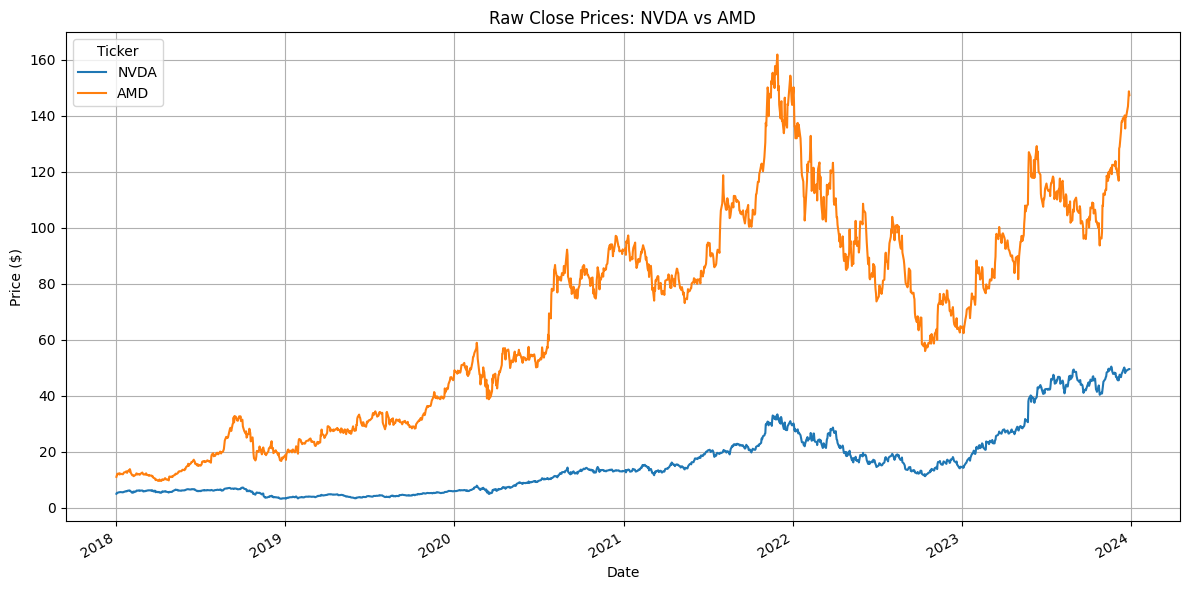

In [56]:
# Extract just the 'Close' prices from the MultiIndex DataFrame
close_prices = raw_data['Close'][['NVDA', 'AMD']]

close_prices.plot(title='Raw Close Prices: NVDA vs AMD', figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

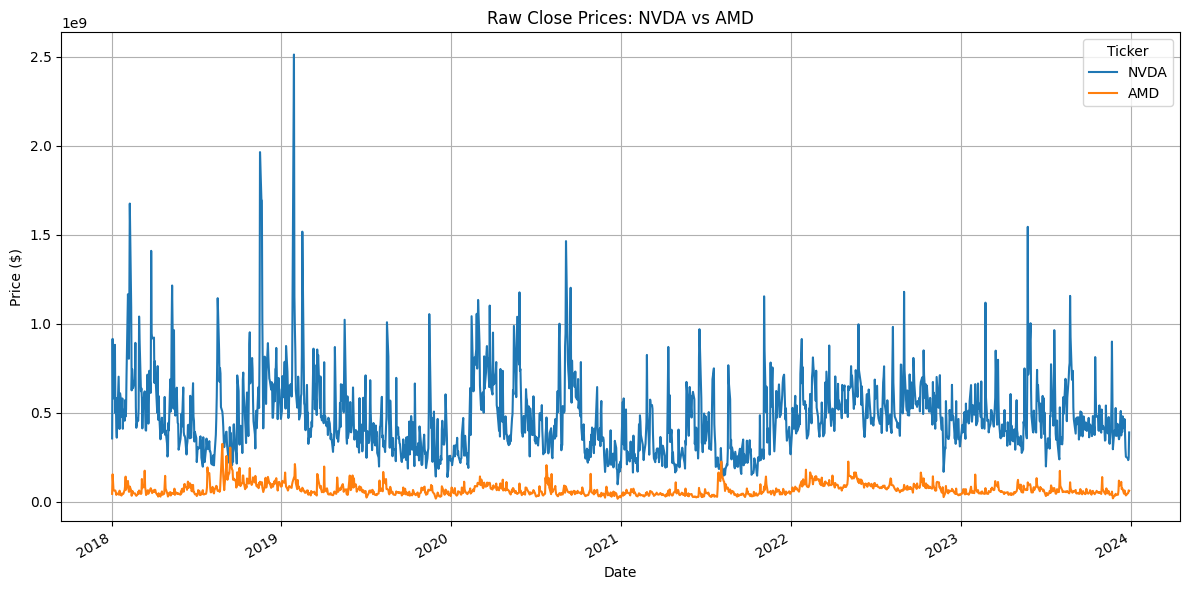

In [57]:
# Extract just the 'Volume' amount
close_prices = raw_data['Volume'][['NVDA', 'AMD']]

close_prices.plot(title='Raw Close Prices: NVDA vs AMD', figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
# Use log prices for cointegration analysis (and mean-reverting spread).

log_prices = np.log(close_prices)
log_prices.head()

Ticker,NVDA,AMD
Date,,
2018-01-02,19.689362,17.603020
2018-01-03,20.634111,18.852896
2018-01-04,20.184157,18.511463
2018-01-05,20.178752,17.971403
2018-01-08,20.596813,17.964122


Run the Engle-Granger test to see if NVDA and AMD are cointegrated.

If p-value < 0.05, the pair is cointegrated and suitable for trading.

In [59]:
# Run the test
score, pvalue, _ = coint(log_prices['NVDA'], log_prices['AMD'])
print(f"Cointegration p-value: {pvalue:.4f}")

Cointegration p-value: 0.0000


NVDA and AMD are cointegrated — i.e., whether their prices move together in the long term in a stable relationship.So their price spread is mean-reverting — this is the perfect condition for a pairs trading strategy.

Hedge ratio (β): 0.3911


/var/folders/g4/p1zk819j01n4w5h7tdlp7cp40000gn/T/ipykernel_50829/1073830852.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


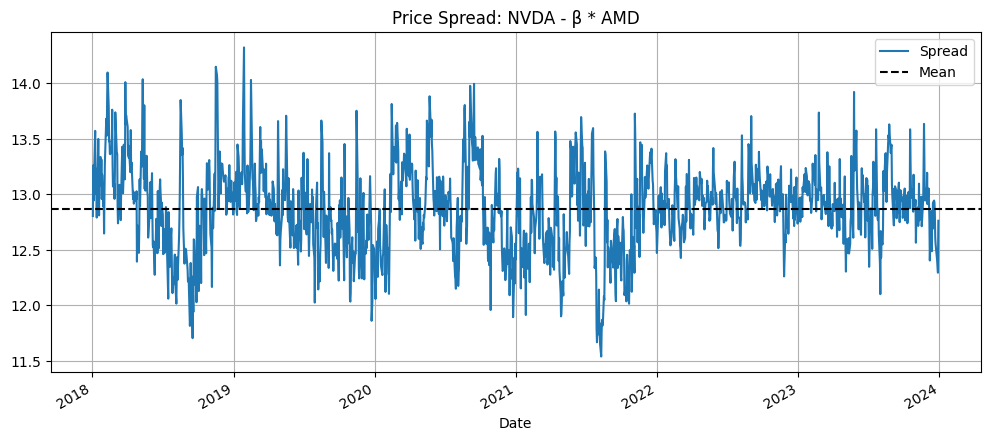

In [60]:
# Regress NVDA on AMD to estimate hedge ratio
X = sm.add_constant(log_prices['AMD'])
model = sm.OLS(log_prices['NVDA'], X).fit()
hedge_ratio = model.params[1]

print(f"Hedge ratio (β): {hedge_ratio:.4f}")

# Calculate the spread
spread = log_prices['NVDA'] - hedge_ratio * log_prices['AMD']
spread.name = "Spread"
spread.plot(title="Price Spread: NVDA - β * AMD", figsize=(12, 5))
plt.axhline(spread.mean(), color='black', linestyle='--', label="Mean")
plt.legend()
plt.grid(True)
plt.show()

The graph shows how the price relationship between NVIDIA (NVDA) and AMD changes over time. Specifically, it plots the spread, which is a measure of how far apart their prices are after adjusting for scale. 

The dashed horizontal line is the average (mean) spread, and the blue line moves above or below this average depending on whether NVDA is becoming relatively more expensive or cheaper than AMD. When the line is far above the mean, NVDA is overpriced relative to AMD; when it's far below, NVDA is underpriced. 

The idea behind pairs trading is to profit when this spread returns to the average, by buying the cheap stock and shorting the expensive one.


Calcuate the Z-score of the spread; Tthis standardizes the spread so we can easily spot extreme values.


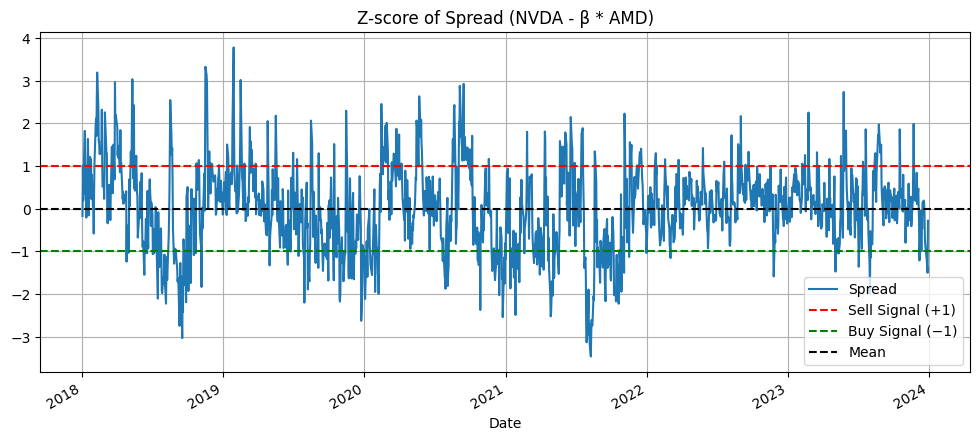

In [61]:
# Calculate z-score of the spread
zscore = (spread - spread.mean()) / spread.std()

# Plot the z-score
zscore.plot(title='Z-score of Spread (NVDA - β * AMD)', figsize=(12, 5))
plt.axhline(1, color='red', linestyle='--', label='Sell Signal (+1)')
plt.axhline(-1, color='green', linestyle='--', label='Buy Signal (−1)')
plt.axhline(0, color='black', linestyle='--', label='Mean')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Create signals based on z-score thresholds
signals = pd.DataFrame(index=zscore.index)
signals['zscore'] = zscore
signals['long'] = (zscore < -1).astype(int)     # Buy NVDA, Sell AMD
signals['short'] = (zscore > 1).astype(int)     # Sell NVDA, Buy AMD
signals['exit'] = (zscore.abs() < 0.5).astype(int)  # Exit positions

In [63]:
positions = pd.DataFrame(index=signals.index, columns=['NVDA', 'AMD'], dtype=float)
in_position = False

# Trade logic
for i in range(1, len(signals)):
    if signals.iloc[i]['long'] and not in_position:
        positions.iloc[i] = [1, -hedge_ratio]
        in_position = True
    elif signals.iloc[i]['short'] and not in_position:
        positions.iloc[i] = [-1, hedge_ratio]
        in_position = True
    elif signals.iloc[i]['exit'] and in_position:
        positions.iloc[i] = [0, 0]
        in_position = False
    else:
        positions.iloc[i] = positions.iloc[i - 1]


# Normalize trade sizes to fixed dollar amount (e.g., $10,000 per trade leg)
dollar_exposure = 10000

# Convert from share positions to dollar positions
positions['NVDA'] = positions['NVDA'] * dollar_exposure / close_prices['NVDA']
positions['AMD'] = positions['AMD'] * dollar_exposure / close_prices['AMD']



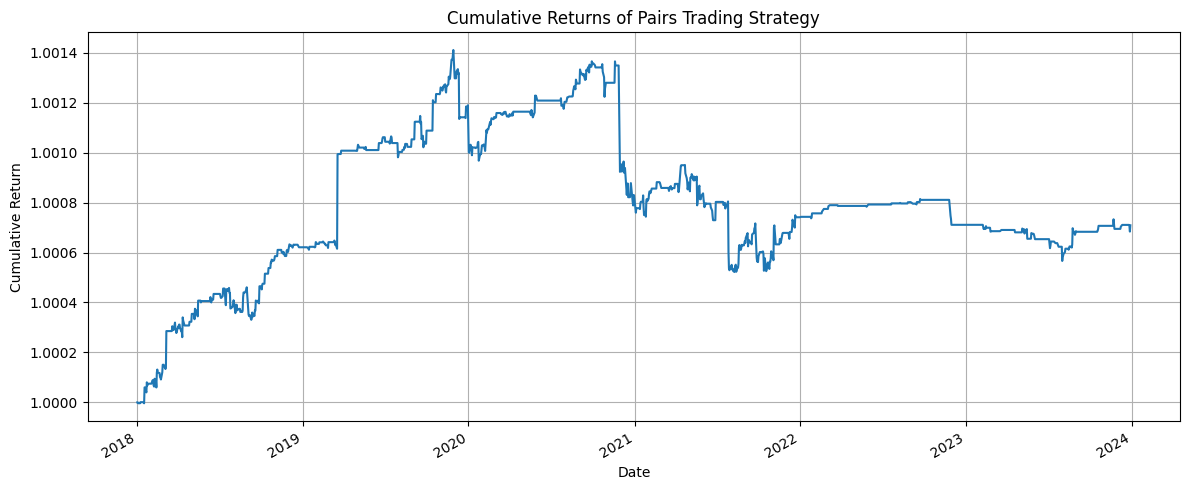

In [64]:
# Daily returns of NVDA and AMD
# 1. Daily % returns of NVDA and AMD
returns = close_prices.pct_change().fillna(0)

# 2. Daily profit/loss from strategy (P&L)
# Multiply yesterday’s position by today’s return
pnl = (positions.shift(1) * returns).sum(axis=1)

# 3. Cumulative return over time
cumulative_returns = (1 + pnl).cumprod()

# 4. Plot the strategy's growth
cumulative_returns.plot(title="Cumulative Returns of Pairs Trading Strategy", figsize=(12, 5))
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

The cumulative returns graph shows how the strategy’s value evolved from 2018 to 2024. It initially performed well, with steady gains through 2020, followed by a noticeable plateau and gradual decline in the following years. This pattern suggests that the price relationship between NVDA and AMD was mean-reverting early on, but weakened or became less consistent over time, reducing the strategy’s profitability.

In [65]:
# Annualized Sharpe ratio
sharpe_ratio = pnl.mean() / pnl.std() * np.sqrt(252)

# Max Drawdown
drawdown = (cumulative_returns / cumulative_returns.cummax()) - 1
max_drawdown = drawdown.min()

# Print summary
print(f"📈 Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"📉 Max Drawdown: {max_drawdown:.2%}")


📈 Sharpe Ratio: 0.31
📉 Max Drawdown: -0.09%


The Sharpe ratio of 0.31 indicates the strategy had low risk-adjusted returns — not particularly strong, but not disastrous either. However, the max drawdown of just -0.09% shows the strategy was extremely stable and didn’t experience large losses, making it low-risk but also low-reward.